In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [95]:
df = pd.read_csv('rnn.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [96]:
df.head()

,Production
Date,
2014-01-01,59.478899
2014-02-01,93.466842
2014-03-01,46.733421
2014-04-01,89.218349
2014-05-01,46.733421


<AxesSubplot:xlabel='Date'>

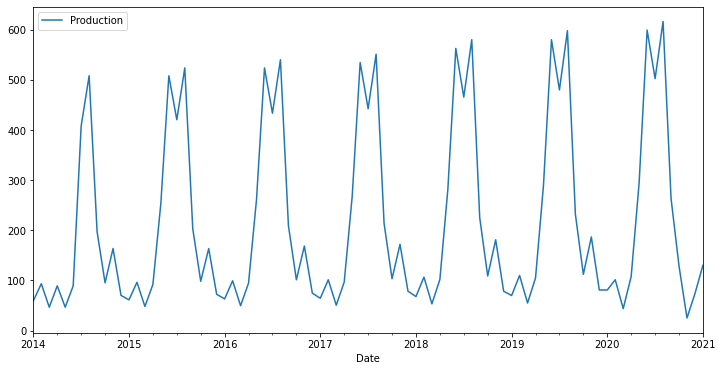

In [97]:
df.plot(figsize=(12,6))

In [98]:
from statsmodels.tsa.seasonal import seasonal_decompose

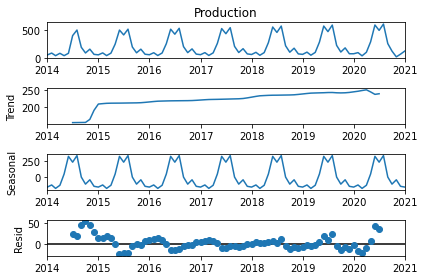

In [99]:
results = seasonal_decompose(df['Production'])
results.plot();

In [100]:
len(df)

85

In [130]:
train = df.iloc[:72]
test = df.iloc[72:]

In [131]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [132]:
df.head(),df.tail()

(            Production
 Date                  
 2014-01-01   59.478899
 2014-02-01   93.466842
 2014-03-01   46.733421
 2014-04-01   89.218349
 2014-05-01   46.733421,
             Production
 Date                  
 2020-09-01      263.76
 2020-10-01      129.00
 2020-11-01       25.20
 2020-12-01       73.80
 2021-01-01      130.20)

In [133]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [134]:
scaled_train[:10]

array([[0.02312035],
       [0.08477463],
       [0.        ],
       [0.07706785],
       [0.        ],
       [0.07706785],
       [0.6550767 ],
       [0.83695681],
       [0.27282018],
       [0.08816562]])

In [135]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [136]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [137]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [138]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [139]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.02312035 0.08477463 0.        ]
Predict this y: 
 [[0.07706785]]


In [140]:
X.shape

(1, 3, 1)

In [141]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [142]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [143]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [144]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [145]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
60/60 [==============================] - 1s 3ms/step - loss: 0.1295
Epoch 2/50
60/60 [==============================] - 0s 2ms/step - loss: 0.1071
Epoch 3/50
60/60 [==============================] - 0s 2ms/step - loss: 0.0966
Epoch 4/50
60/60 [==============================] - 0s 2ms/step - loss: 0.0844
Epoch 5/50
60/60 [==============================] - 0s 2ms/step - loss: 0.0689
Epoch 6/50
60/60 [==============================] - 0s 2ms/step - loss: 0.0465
Epoch 7/50
60/60 [==============================] - 0s 2ms/step - loss: 0.0561
Epoch 8/50
60/60 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 9/50
60/60 [==============================] - 0s 2ms/step - loss: 0.0344
Epoch 10/50
60/60 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 11/50
60/60 [==============================] - 0s 2ms/step - loss: 0.0324
Epoch 12/50
60/60 [==============================] - 0s 2ms/step - loss: 0.0206
Epoch 13/50
60/60 [==============================

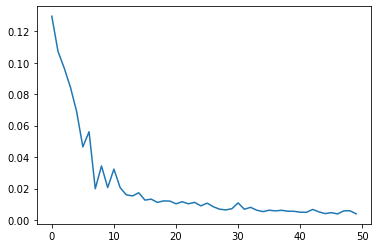

In [146]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [147]:
last_train_batch = scaled_train[-12:]

In [148]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [149]:
model.predict(last_train_batch)

array([[0.05253003]], dtype=float32)

In [150]:
scaled_test[0]

array([0.06215973])

In [151]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [152]:
test_predictions

[array([0.05253003], dtype=float32),
 array([0.04906324], dtype=float32),
 array([0.04222568], dtype=float32),
 array([0.12758285], dtype=float32),
 array([0.47420576], dtype=float32),
 array([0.9829424], dtype=float32),
 array([0.872731], dtype=float32),
 array([1.0188966], dtype=float32),
 array([0.36594555], dtype=float32),
 array([0.16895735], dtype=float32),
 array([0.18848044], dtype=float32),
 array([0.07720875], dtype=float32),
 array([0.04891197], dtype=float32)]

In [153]:
test.head()

,Production
Date,
2020-01-01,81.0
2020-02-01,101.4
2020-03-01,43.8
2020-04-01,108.0
2020-05-01,295.2


In [154]:
true_predictions = scaler.inverse_transform(test_predictions)

In [155]:
test['Predictions'] = true_predictions

<ipython-input-155-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='Date'>

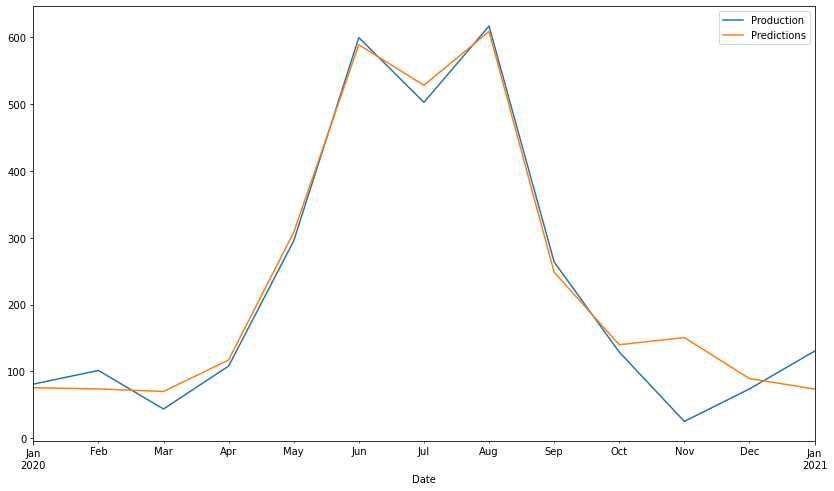

In [158]:
test.plot(figsize=(14,8))

In [159]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

41.20613378063448
